# Yelp Sentiment Analysis with doc2vec Document Vectors

## Imports & Settings

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import logging
import warnings
from random import shuffle
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight
import seaborn as sns
import umap

### Settings

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Paths

In [7]:
yelp_path = Path('data', 'doc2vec')

### Logging Config

In [6]:
logging.basicConfig(
        filename=yelp_path / 'doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

Refer to download information in [yelp_sentiment](../14_working_with_text_data/06_sentiment_analysis_yelp.ipynb)

In [45]:
df = pd.read_parquet(yelp_path / 'combined.parquet').loc[:, ['stars', 'text']]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996995 entries, 0 to 5996995
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   stars   int64 
 1   text    object
dtypes: int64(1), object(1)
memory usage: 137.3+ MB


In [46]:
df.stars.value_counts()

5    2641880
4    1335957
1     858139
3     673206
2     487813
Name: stars, dtype: int64

In [48]:
stars = range(1, 6)

In [49]:
sample = pd.concat([df[df.stars==s].sample(n=100000) for s in stars])

In [50]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 4766182 to 297039
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   500000 non-null  int64 
 1   text    500000 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.4+ MB


In [51]:
sample.stars.value_counts()

5    100000
4    100000
3    100000
2    100000
1    100000
Name: stars, dtype: int64

In [52]:
sample.to_parquet('yelp_sample.parquet')

In [53]:
sample = pd.read_parquet('yelp_sample.parquet').reset_index(drop=True)

In [54]:
sample.head()

,stars,text
0,1,Probably will not be going back there again. T...
1,1,"Horrible check in, rooms are ok, expected nice..."
2,1,Worst experience ever.... I guess it's my firs...
3,1,I only gave one star because if I could have g...
4,1,yall didnt say the wifi wasn't free im crying ...


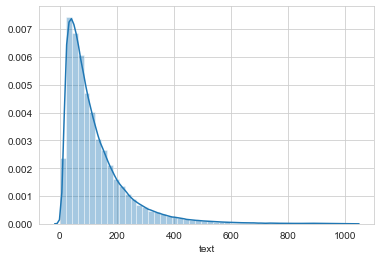

In [56]:
sns.distplot(sample.text.str.split().str.len());

## Doc2Vec

### Basic text cleaning

In [57]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def clean(review):
    tokens = tokenizer.tokenize(review)
    return ' '.join([t for t in tokens if t not in stopword_set])

In [58]:
sample.text = sample.text.str.lower().apply(clean)

In [59]:
sample.sample(n=10)

,stars,text
135859,2,love dumplings excited find dumpling restauran...
471019,5,love little gem hidden residential area friend...
226049,3,yummy place really good got basic brew kettle ...
329475,4,daughter law ate patio last night wanted try f...
371464,4,restaurant friendly customers went order takeo...
79098,1,sugarloaf puppy package help save money spent ...
342571,4,good food good price flavorful fresh ingredien...
374920,4,pho expert couple times life xinh xinh makes p...
289733,3,simply worth hype received online good food gi...
302655,4,authentic persian food white table cloth setti...


In [60]:
sample = sample[sample.text.str.split().str.len()>10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485825 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   485825 non-null  int64 
 1   text    485825 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


### Create sentence stream

In [61]:
sentences = []
for i, (_, text) in enumerate(sample.values):
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

### Formulate the model

In [63]:
model = Doc2Vec(documents=sentences,
                dm=1,           # 1=distributed memory, 0=dist.BOW
                epochs=5,
                size=300,       # vector size
                window=5,       # max. distance betw. target and context
                min_count=50,   # ignore tokens w. lower frequency
                negative=5,     # negative training samples
                dm_concat=0,    # 1=concatenate vectors, 0=sum
                dbow_words=0,   # 1=train word vectors as well
                workers=8)

In [114]:
pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])

In [65]:
model.save((yelp_path / 'sample.model').as_posix())

### Continue training

In [28]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [115]:
most_similar = pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])
most_similar

,token,similarity
0,great,0.772776
1,decent,0.753359
2,amazing,0.633250
3,awesome,0.630964
4,bad,0.614564
5,alright,0.611679
6,tasty,0.605093
7,ok,0.597295
8,fantastic,0.592754
9,excellent,0.587356


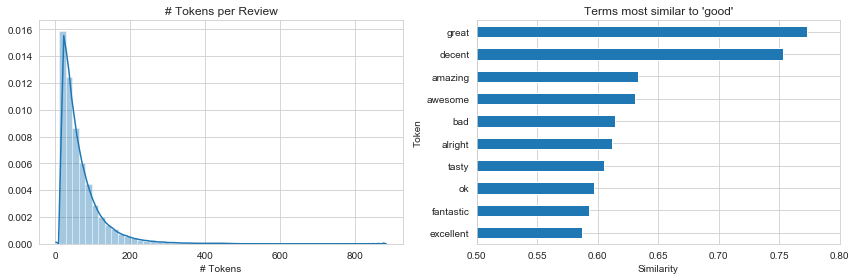

In [120]:
fig, axes =plt.subplots(ncols=2, figsize=(12, 4))
sns.distplot(sample.text.str.split().str.len(), ax=axes[0])
axes[0].set_title('# Tokens per Review')

most_similar.set_index('token').similarity.sort_values().plot.barh(ax=axes[1], 
                                                                   title="Terms most similar to 'good'",
                                                                  xlim=(.5, .8))
axes[1].set_xlabel('Similarity')
axes[1].set_ylabel('Token')
axes[0].set_xlabel('# Tokens')

fig.tight_layout()

## Persist Model

In [30]:
model = Doc2Vec.load((yelp_path / 'sample.model').as_posix())

## Evaluate

In [66]:
y = sample.stars.sub(1)

In [67]:
X = np.zeros(shape=(len(y), size))
for i in range(len(sample)):
    X[i] = model.docvecs[i]

In [68]:
X.shape

(485825, 300)

### Train-Test Split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [70]:
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 20.15%


In [71]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [72]:
class_weights

array([0.99398992, 0.99272049, 0.99616819, 1.0023598 , 1.01509611])

## LightGBM

In [73]:
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = train_data.create_valid(X_test, label=y_test)

In [74]:
params = {'objective': 'multiclass',
          'num_classes': 5}

In [77]:
lgb_model = lgb.train(params=params,
                      train_set=train_data,
                      num_boost_round=5000,
                      valid_sets=[train_data, test_data],
                      early_stopping_rounds=25,
                      verbose_eval=50)

Training until validation scores don't improve for 25 rounds
[50]	training's multi_logloss: 1.40611	valid_1's multi_logloss: 1.42397
[100]	training's multi_logloss: 1.32593	valid_1's multi_logloss: 1.35905
[150]	training's multi_logloss: 1.26924	valid_1's multi_logloss: 1.31605
[200]	training's multi_logloss: 1.2232	valid_1's multi_logloss: 1.2831
[250]	training's multi_logloss: 1.1843	valid_1's multi_logloss: 1.25657
[300]	training's multi_logloss: 1.15074	valid_1's multi_logloss: 1.2351
[350]	training's multi_logloss: 1.12169	valid_1's multi_logloss: 1.21752
[400]	training's multi_logloss: 1.09649	valid_1's multi_logloss: 1.20386
[450]	training's multi_logloss: 1.07407	valid_1's multi_logloss: 1.19265
[500]	training's multi_logloss: 1.05405	valid_1's multi_logloss: 1.18348
[550]	training's multi_logloss: 1.03549	valid_1's multi_logloss: 1.17561
[600]	training's multi_logloss: 1.01826	valid_1's multi_logloss: 1.1687
[650]	training's multi_logloss: 1.00103	valid_1's multi_logloss: 1.16

In [99]:
lgb_pred = np.argmax(lgb_model.predict(X_test), axis=1)

In [100]:
lgb_acc = accuracy_score(y_true=y_test, y_pred=lgb_pred)
print(f'Accuracy: {lgb_acc:.2%}')

Accuracy: 62.24%


## Random Forest

In [93]:
rf = RandomForestClassifier(n_jobs=-1,  
                            n_estimators=500,
                            class_weight='balanced_subsample')
rf.fit(X_train, y_train)

Accuracy: 41.50%


In [95]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Accuracy: {rf_acc:.2%}')

Accuracy: 41.50%


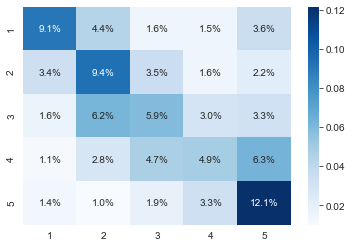

In [96]:
cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Multinomial Logistic Regression

In [85]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
lr.fit(X_train, y_train)

Accuracy: 39.81%


In [97]:
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=lr_pred)
print(f'Accuracy: {lr_acc:.2%}')

Accuracy: 39.81%


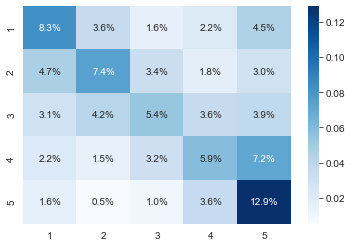

In [98]:
cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Comparison

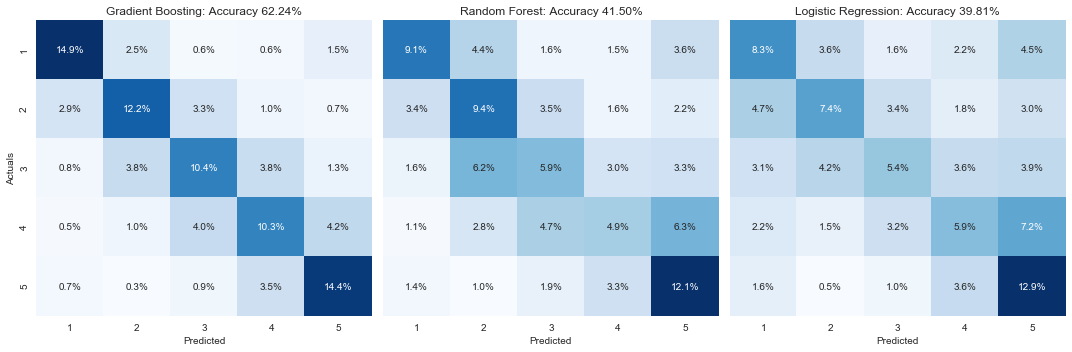

In [110]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

lgb_cm = confusion_matrix(y_true=y_test, y_pred=lgb_pred)
sns.heatmap(pd.DataFrame(lgb_cm/np.sum(lgb_cm), index=stars, columns=stars), 
            annot=True, cmap='Blues', fmt='.1%', ax=axes[0], cbar=False)
axes[0].set_title(f'Gradient Boosting: Accuracy {lgb_acc:.2%}')

rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(rf_cm/np.sum(rf_cm), index=stars, columns=stars), 
            annot=True, cmap='Blues', fmt='.1%', ax=axes[1], cbar=False)
axes[1].set_title(f'Random Forest: Accuracy {rf_acc:.2%}')

lr_cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(lr_cm/np.sum(lr_cm), index=stars, columns=stars), 
            annot=True, cmap='Blues', fmt='.1%', ax=axes[2], cbar=False)
axes[2].set_title(f'Logistic Regression: Accuracy {lr_acc:.2%}')
axes[0].set_ylabel('Actuals')
for i in range(3):
    axes[i].set_xlabel('Predicted')

fig.tight_layout()
fig.savefig('../figures/confusion_matrix', dpi=300);